<h1>Preprocessing PDMC N Panel</h1>

In [1]:
from warnings import simplefilter
simplefilter("ignore", category=FutureWarning) 
simplefilter("ignore", category=UserWarning)
import sys
if '/home/rossco/immunova' not in sys.path:
    sys.path.append('/home/rossco/immunova')
from immunova.data.mongo_setup import pd_init
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating, Template
from immunova.flow.gating.defaults import ChildPopulationCollection
from tqdm import tqdm_notebook
import matplotlib
import pandas as pd
import os
pd_init()

In [2]:
nexp = FCSExperiment.objects(experiment_id='PD_N_PDMCs').get()

In [3]:
nexp.delete_all_populations(sample_id='all', remove_gates=True)

In [4]:
nexp.delete_gating_templates(template_name='all')

In [5]:
nexp.list_samples()

['142-09_pdmc_n',
 '209-05_pdmc_n',
 '210-14_pdmc_n',
 '239-02_pdmc_n',
 '239-04_pdmc_n',
 '251-07_pdmc_n',
 '251-08_pdmc_n',
 '254-04_pdmc_n',
 '254-05_pdmc_n',
 '255-04_pdmc_n',
 '255-05_pdmc_n',
 '264-02_pdmc_n',
 '267-02_pdmc_n',
 '273-01_pdmc_n',
 '276-01_pdmc_n',
 '286-03_pdmc_n',
 '286-04_pdmc_n',
 '294-02_pdmc_n',
 '294-03_pdmc_n',
 '298-01_pdmc_n',
 '305-01_pdmc_n',
 '305-02_pdmc_n',
 '305-03_pdmc_n',
 '306-01_pdmc_n',
 '308-01_pdmc_n',
 '308-02R_pdmc_n',
 '308-03R_pdmc_n',
 '310-01_pdmc_n',
 '315-01_pdmc_n',
 '315-02_pdmc_n',
 '318-01_pdmc_n',
 '320-01_pdmc_n',
 '321-01_pdmc_n',
 '322-01_pdmc_n',
 '323-01_pdmc_n',
 '324-01_pdmc_n',
 '326-01_pdmc_n',
 '237-06_pdmc_n',
 '267-01_pdmc_n',
 '279-03_pdmc_n',
 '286-02_pdmc_n',
 '288-02_pdmc_n',
 '302-01_pdmc_n']

<h2>Create a Template</h2>

We will use the automated gates to isolate single Live CD45+ cells (all leukocytes).

In [6]:
n = Template(nexp, '142-09_pdmc_n', include_controls=False)

In [7]:
n.clear_gates()

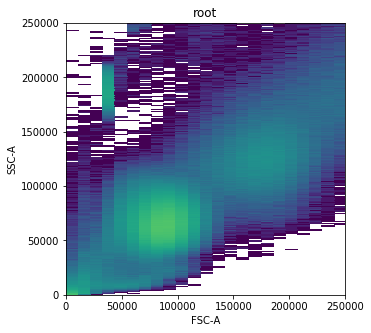

In [8]:
n.plotting.plot_population('root', 'FSC-A', 'SSC-A', transforms={'x':None, 'y':None})

------ boundary ------
New population: cells
...proportion of total events: 0.792
...proportion of parent: 0.792
New population: debris
...proportion of total events: 0.208
...proportion of parent: 0.208
-----------------------


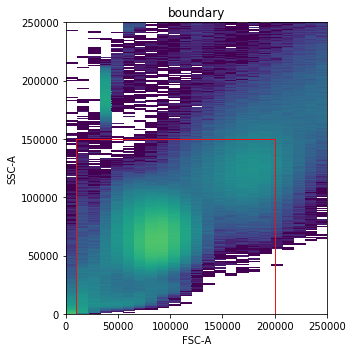

In [9]:
children = ChildPopulationCollection('geom')
children.add_population('cells', definition='+')
children.add_population('debris', definition='-')
kwargs = dict(x='FSC-A', y='SSC-A', transform_x=None, transform_y=None,
             x_min=10000, y_min=0, x_max=200000, y_max=150000)
n.create_gate(gate_name='boundary', 
              parent='root',
              class_='Static',
              method='rect_gate',
              child_populations=children, 
              kwargs=kwargs)
n.apply('boundary')

------ CD45_gate ------
New population: CD45+
...proportion of total events: 0.759
...proportion of parent: 0.958
-----------------------


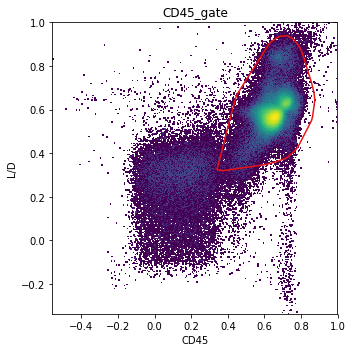

In [10]:
children = ChildPopulationCollection('cluster')
children.add_population('CD45+', target=(0.6, 0.6), weight=1)
kwargs = dict(x='CD45', y='L/D', transform_x='logicle', 
              transform_y='logicle', min_pop_size=100, frac=0.01)
n.create_gate(gate_name='CD45_gate', 
              parent='cells',
              class_='DensityBasedClustering',
              method='hdbscan',
              child_populations=children, 
              kwargs=kwargs)
n.apply('CD45_gate')

------ live_gate ------
New population: dead
...proportion of total events: 0.038
...proportion of parent: 0.050
New population: Live_CD45+
...proportion of total events: 0.721
...proportion of parent: 0.950
-----------------------


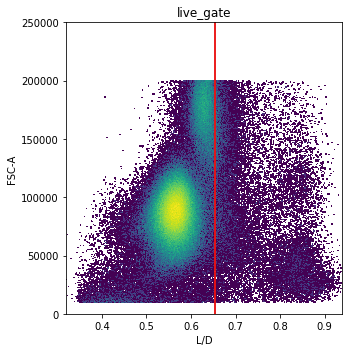

In [11]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('dead', definition='+')
children.add_population('Live_CD45+', definition='-')
kwargs = dict(x='L/D', transform_x='logicle', kde_bw=0.05, low_memory=True, peak_threshold=0.05)
n.create_gate(gate_name='live_gate', 
              parent='CD45+',
              class_='DensityThreshold',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
n.apply('live_gate')

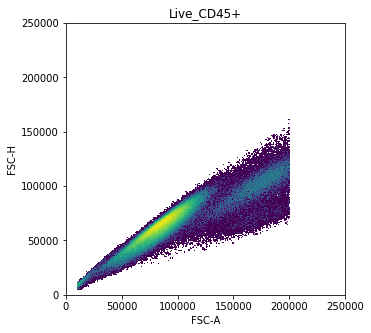

In [12]:
n.plotting.plot_population('Live_CD45+', 'FSC-A', 'FSC-H', transforms={'x':None,
                                                                       'y':None})

------ singlets1_gate ------
New population: singlets1
...proportion of total events: 0.630
...proportion of parent: 0.874
New population: doublets1
...proportion of total events: 0.091
...proportion of parent: 0.126
-----------------------


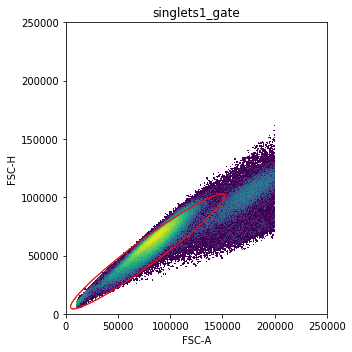

In [13]:
children = ChildPopulationCollection('geom')
children.add_population('singlets1', definition='+')
children.add_population('doublets1', definition='-')
kwargs = dict(x='FSC-A', y='FSC-H', transform_x=None, transform_y=None, target=(75000, 60000),
             conf=0.99)
n.create_gate(gate_name='singlets1_gate', 
              parent='Live_CD45+',
              class_='MixtureModel',
              method='gate',
              child_populations=children, 
              kwargs=kwargs)
n.apply('singlets1_gate')

------ singlets2_gate ------
New population: doublets2
...proportion of total events: 0.031
...proportion of parent: 0.050
New population: Single_Live_CD45+
...proportion of total events: 0.598
...proportion of parent: 0.950
-----------------------


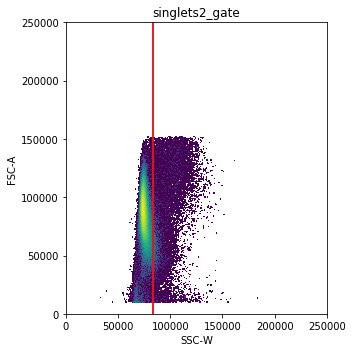

In [14]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('doublets2', definition='+')
children.add_population('Single_Live_CD45+', definition='-')
kwargs = dict(x='SSC-W', transform_x=None, kde_bw=5000, low_memory=True,
             ignore_double_pos=False, peak_threshold=0.05)
n.create_gate(gate_name='singlets2_gate', 
              parent='singlets1',
              class_='DensityThreshold',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
n.apply('singlets2_gate')

In [15]:
n.print_population_tree()

root
├── cells
│   └── CD45+
│       ├── dead
│       └── Live_CD45+
│           ├── singlets1
│           │   ├── doublets2
│           │   └── Single_Live_CD45+
│           └── doublets1
└── debris


In [16]:
n.save_new_template('PDMCn_Preprocessing', overwrite=True)

No existing template named PDMCn_Preprocessing, creating new template


True

<h3>Secondary template</h3>

In [6]:
n = Template(nexp, '254-05_pdmc_n', include_controls=False)
n.clear_gates()

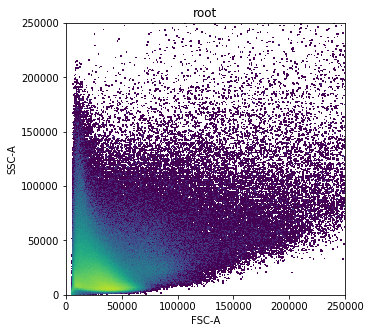

In [7]:
n.plotting.plot_population('root', 'FSC-A', 'SSC-A', transforms={'x':None, 'y':None})

------ boundary ------
New population: cells
...proportion of total events: 0.937
...proportion of parent: 0.937
New population: debris
...proportion of total events: 0.063
...proportion of parent: 0.063
-----------------------


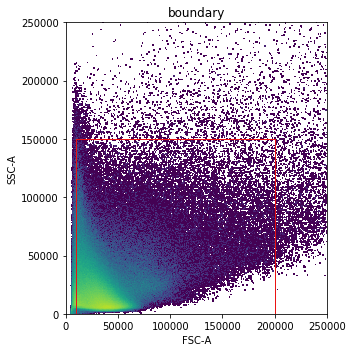

In [8]:
children = ChildPopulationCollection('geom')
children.add_population('cells', definition='+')
children.add_population('debris', definition='-')
kwargs = dict(x='FSC-A', y='SSC-A', transform_x=None, transform_y=None,
             x_min=10000, y_min=0, x_max=200000, y_max=150000)
n.create_gate(gate_name='boundary', 
              parent='root',
              class_='Static',
              method='rect_gate',
              child_populations=children, 
              kwargs=kwargs)
n.apply('boundary')

------ CD45_gate ------
New population: CD45+
...proportion of total events: 0.052
...proportion of parent: 0.055
New population: CD45-
...proportion of total events: 0.885
...proportion of parent: 0.945
-----------------------


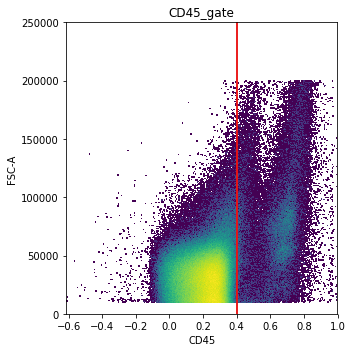

In [9]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('CD45+', definition='+')
children.add_population('CD45-', definition='-')
kwargs = dict(x='CD45', transform_x='logicle', kde_bw=0.02, low_memory=True, peak_threshold=0.05,
             ignore_double_pos=True)
n.create_gate(gate_name='CD45_gate', 
              parent='cells',
              class_='DensityThreshold',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
n.apply('CD45_gate')

------ live_gate ------
New population: dead
...proportion of total events: 0.003
...proportion of parent: 0.050
New population: Live_CD45+
...proportion of total events: 0.049
...proportion of parent: 0.950
-----------------------


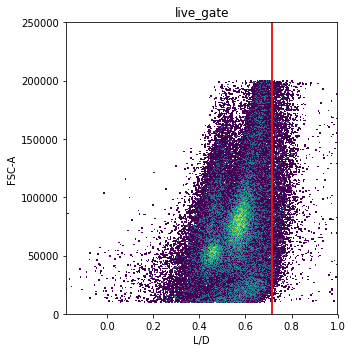

In [10]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('dead', definition='+')
children.add_population('Live_CD45+', definition='-')
kwargs = dict(x='L/D', transform_x='logicle', kde_bw=0.05, low_memory=True, peak_threshold=0.05,
             ignore_double_pos=True)
n.create_gate(gate_name='live_gate', 
              parent='CD45+',
              class_='DensityThreshold',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
n.apply('live_gate')

------ singlets_gate ------
New population: doublets
...proportion of total events: 0.002
...proportion of parent: 0.050
New population: Single_Live_CD45+
...proportion of total events: 0.047
...proportion of parent: 0.950
-----------------------


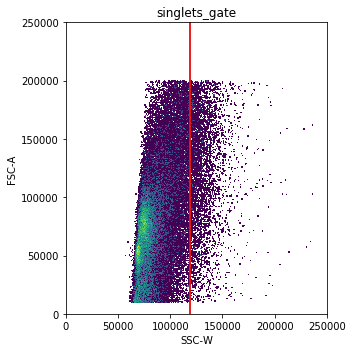

In [11]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('doublets', definition='+')
children.add_population('Single_Live_CD45+', definition='-')
kwargs = dict(x='SSC-W', transform_x=None, q=0.95)
n.create_gate(gate_name='singlets_gate', 
              parent='Live_CD45+',
              class_='Quantile',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
n.apply('singlets_gate')

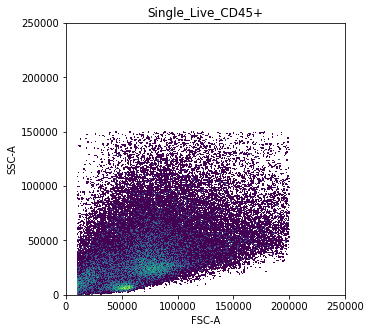

In [14]:
n.plotting.plot_population('Single_Live_CD45+', 'FSC-A', 'SSC-A', transforms={'x': None, 'y': None})

In [15]:
n.print_population_tree()

root
├── cells
│   ├── CD45+
│   │   ├── dead
│   │   └── Live_CD45+
│   │       ├── doublets
│   │       └── Single_Live_CD45+
│   └── CD45-
└── debris


In [16]:
n.save_new_template('PDMCn_Preprocessing_Secondary', overwrite=True)

No existing template named PDMCn_Preprocessing_Secondary, creating new template


True

In [17]:
import os
from notebook.services.contents.filemanager import FileContentsManager as FCM
for x in nexp.list_samples():
    notebook_fname = f'{x}.ipynb'
    if not os.path.exists(notebook_fname):
        FCM().new(path=notebook_fname)